In [51]:
#from __future__ import absolute_import, division, print_function, unicode_literals
# Installa TensorFlow
import tensorflow as tf
print(tf.__version__)


2.11.0


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
import numpy as np

Para leer datos lo mejor es usar la toolbox pandas

Los datos se han sacado de:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

In [53]:
import pandas as pd

# Leer los datos 
# En local: tenemos que tener el fichero en la misma carpeta que el notebook (o cambiar la ruta)
# En Colab: abre la carpeta (usando el boton de la izquierda) y arrastralos dentro desde tu ordenador.

dd_googl = pd.read_csv("datos/googl.us.txt", delimiter=",")
dd_aa = pd.read_csv("datos/aa.us.txt", delimiter=",")
dd_iae = pd.read_csv("datos/iae.us.txt", delimiter=",")


In [54]:
# Estos son los datos de google
dd_googl

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


In [55]:
# Nos quedamos con los datos de apertura
googl_op = dd_googl['Open'].values
aa_op = dd_aa['Open'].values
iae_op = dd_iae['Open'].values

In [56]:
# Como no coinciden en el tiempo los 3 valores me cojo solo los que coinciden
# Primero me los ordeno teniendo en cuenta la fecha
aa = dd_googl['Date'].values
googl_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [57]:
aa = dd_aa['Date'].values
aa_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    aa_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [58]:
aa = dd_iae['Date'].values
iae_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    iae_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [59]:
print(googl_indice.shape)
print(googl_op.shape)

(3333,)
(3333,)


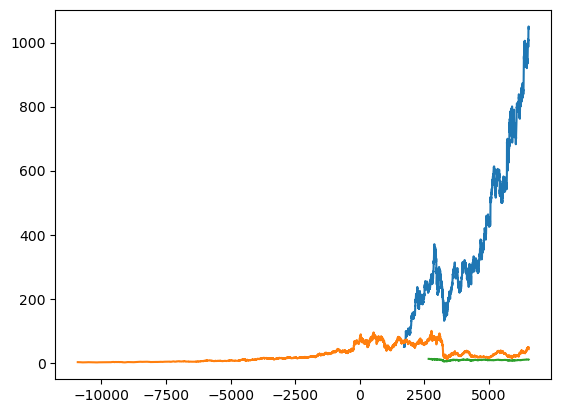

In [60]:
# Los ploteo y veo que hay un tramo en el coinciden las fechas
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(googl_indice,googl_op)
plt.plot(aa_indice,aa_op)
plt.plot(iae_indice,iae_op)

In [61]:
# Me quedo solo las fechas que coinciden
indices = set(googl_indice) & set(aa_indice) & set(iae_indice) 

ii = np.in1d(googl_indice,list(indices))
data_googl = googl_op[ii]
ii = np.in1d(aa_indice,list(indices))
data_aa = aa_op[ii]
ii = np.in1d(iae_indice,list(indices))
data_iae = iae_op[ii]

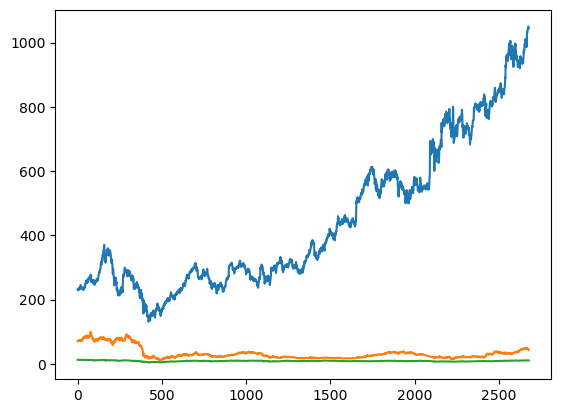

In [62]:
# Los ploteo y ahora síí coinciden en todo el tramo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(data_googl)
plt.plot(data_aa)
plt.plot(data_iae)

In [63]:
# Los coloco todos juntos en un dataset
DAT = np.zeros((data_googl.shape[0],3))
DAT[:,0] = data_googl
DAT[:,1] = data_aa
DAT[:,2] = data_iae
               

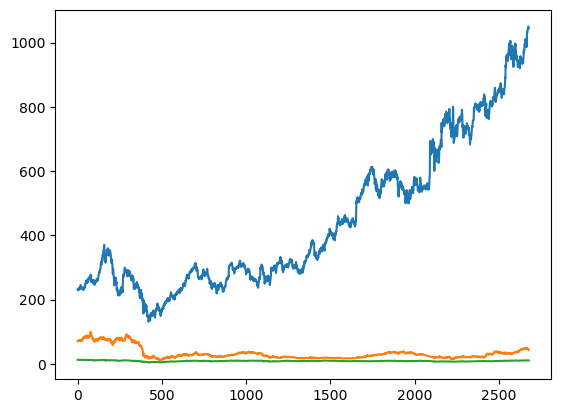

In [64]:
# Los ploteo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(DAT[:,0])
plt.plot(DAT[:,1])
plt.plot(DAT[:,2])

In [65]:
# Dimensiones del dataset
DAT.shape

(2678, 3)

In [66]:
# Reordeno el dataset para hacer bloques de LAG dias
LAG = 11
DAT_TS = np.zeros((DAT.shape[0]-LAG,LAG,DAT.shape[1]))

for ii in range(0,DAT.shape[0]-LAG):
    DAT_TS[ii,:,:] = DAT[ii:ii+LAG,:]
    

In [67]:
# Tengo (#muestras,#longitud,#variables)
DAT_TS.shape

(2667, 11, 3)

In [68]:
# Cojo 14 dias para entrada y el dia 15 de la variable "Y_target" como variable a predecir
# Separo en train y test

Ntr = np.floor(DAT_TS.shape[0]/2)
Y_target = 0

XX_tr = DAT_TS[range(0,int(Ntr)),0:LAG-1,:]
XX_ts = DAT_TS[range(int(Ntr)+1,2*int(Ntr)),0:LAG-1,:]

YY_tr = DAT_TS[range(0,int(Ntr)),LAG-1,Y_target]
YY_ts = DAT_TS[range(int(Ntr)+1,2*int(Ntr)),LAG-1,Y_target]

LAG-1

10

In [69]:
# Los datos de entrada
XX_tr.shape

(1333, 10, 3)

In [70]:
# Los datos a predecir
YY_tr.shape

(1333,)

KERAS MODEL

In [71]:
# Definimos un modelo con una capa convolucional 1D y 1 capa densa
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:],padding='same'))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 10, 10)            100       
                                                                 
 flatten_4 (Flatten)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Otra posibilidad 2 convolucionales 1D y una densa
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 8, 10)             100       
                                                                 
 conv1d_9 (Conv1D)           (None, 6, 10)             310       
                                                                 
 flatten_5 (Flatten)         (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 61        
                                                                 
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Otra posibilidad 2 convolucionales 1D y 2 densas
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Conv1D(10, 3))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 8, 10)             100       
                                                                 
 conv1d_11 (Conv1D)          (None, 6, 10)             310       
                                                                 
 flatten_6 (Flatten)         (None, 60)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                610       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Compilamos el modelo
model.compile(optimizer='adam',loss='mae')

In [75]:
# Entrenamos el modelo. Para guardarnos la evolucióón usando callbacks

# from keras.callbacks import History 
# history = History()

# model.fit(XX_tr, YY_tr, batch_size=32, epochs=100, verbose=1, callbacks=[history])

In [76]:
# Entrenamos el modelo, nos guardamos la evolución en 'history' 
# Esto es equivalente a usar callbacks para history
history = model.fit(XX_tr, YY_tr, batch_size=32, epochs=300, verbose=1)

Epoch 1/300
42/42 [==============================] - 2s 44ms/step - loss: 11.5031
Epoch 2/300
42/42 [==============================] - 2s 36ms/step - loss: 8.6759
Epoch 3/300
42/42 [==============================] - 1s 34ms/step - loss: 8.2892
Epoch 4/300
42/42 [==============================] - 1s 34ms/step - loss: 8.0769
Epoch 5/300
42/42 [==============================] - 1s 34ms/step - loss: 7.3708
Epoch 6/300
42/42 [==============================] - 1s 35ms/step - loss: 7.2356
Epoch 7/300
42/42 [==============================] - 1s 33ms/step - loss: 7.1718
Epoch 8/300
42/42 [==============================] - 1s 34ms/step - loss: 7.2094
Epoch 9/300
42/42 [==============================] - 1s 34ms/step - loss: 6.3052
Epoch 10/300
42/42 [==============================] - 1s 34ms/step - loss: 6.0571
Epoch 11/300
42/42 [==============================] - 1s 36ms/step - loss: 6.0875
Epoch 12/300
42/42 [==============================] - 1s 31ms/step - loss: 5.6686
Epoch 13/300
42/42 [====

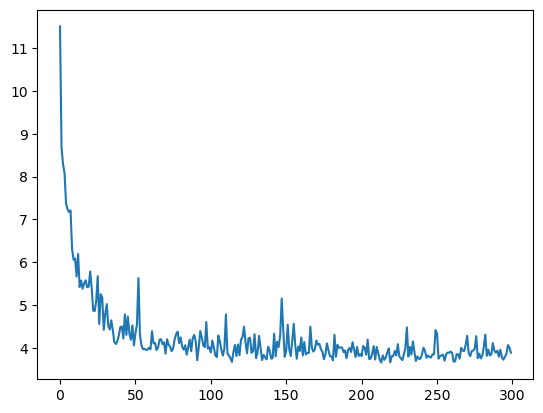

In [77]:
# Mostramos la evolucióón del entrenamiento

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(history.history['loss'][0:])
#plt.plot(history.history['val_loss'][3:])

In [78]:
# Evaluamos el modelo en train
score = model.evaluate(XX_tr, YY_tr, verbose=0)
score

3.55314564704895

In [79]:
# Predecimos con los datos de train
y_hat = model.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

42/42 [==============================] - 0s 3ms/step


3.5531456324469297

In [80]:
y_hat.shape

(1333, 1)

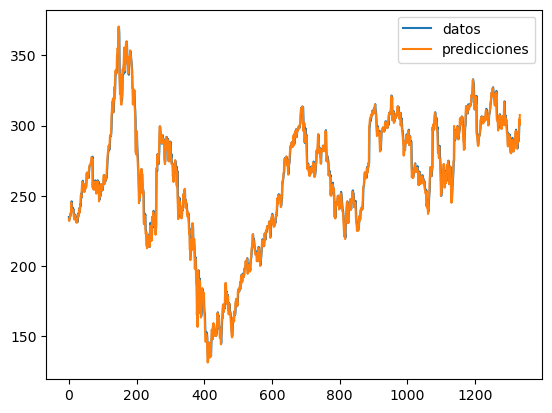

In [81]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_tr, label='predicciones')
plt.legend()

TEST

In [82]:
# Predecimos en test
y_hat = model.predict(XX_ts)
# mostramos el error
np.mean(abs(y_hat[:,0]-YY_ts))

42/42 [==============================] - 0s 3ms/step


6.055631204324441

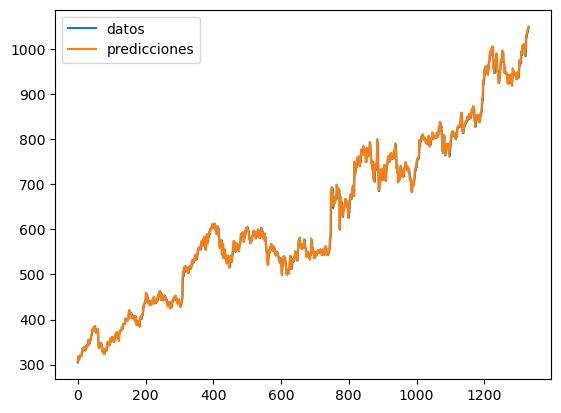

In [83]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_ts, label='predicciones')
plt.legend()

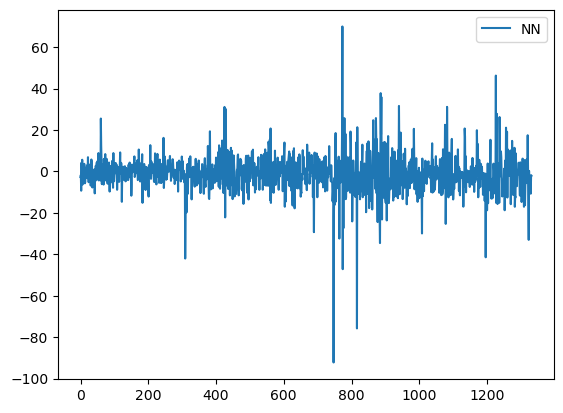

In [84]:
# Estas son las diferencias
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat[:,0]-YY_ts, label='NN')
plt.legend()